在2.ipynb的内容更改数据格式，使模型可以训练

In [1]:
from category_encoders import (
    GLMMEncoder,
    LeaveOneOutEncoder,
    OneHotEncoder,
    OrdinalEncoder,
    TargetEncoder,
    WOEEncoder,
)

from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler

import numpy as np
import pandas as pd
import re
from typing import Optional, Tuple, Union

import matplotlib.pyplot as plt
from xgboost import plot_tree

import warnings
warnings.filterwarnings("ignore")


from bluecast.blueprints.cast import BlueCast
from bluecast.blueprints.cast_cv import BlueCastCV
from bluecast.config.training_config import TrainingConfig, XgboostTuneParamsConfig
from bluecast.preprocessing.custom import CustomPreprocessing
from bluecast.general_utils.general_utils import save_to_production, load_for_production

from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.preprocessing import PowerTransformer, LabelEncoder

In [46]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

print('The dimension of the train dataset is:', train.shape)
print('The dimension of the test dataset is:', test.shape)

The dimension of the train dataset is: (20758, 18)
The dimension of the test dataset is: (13840, 17)


In [47]:
target = "NObeyesdad"

In [3]:
def transform_feats(data):
    data['Gender_binary'] = data['Gender'].map({'Male': 1, 'Female': 0}).astype(int)
    data['family_history_with_overweight_binary'] = data['family_history_with_overweight'].map({'yes': 1, 'no': 0}).astype(int)
    data['SMOKE_binary'] = data['SMOKE'].map({'yes': 1, 'no': 0}).astype(int)
    
    # taken from: https://www.kaggle.com/code/ravi20076/playgrounds4e02-extraftre-models
    data["CAEC"] = data["CAEC"].map({"no": 0, "Sometimes": 1, "Frequently": 2, "Always": 3}).astype(np.uint8)
    data['SCC']  = np.where(data["SCC"] == "no", 1,0).astype(np.uint8)
    data["CALC"] = data["CALC"].map({"no": 0, "Sometimes": 1, "Frequently": 2, "Always": 2}).astype(np.uint8)
    return data

def feature_engineering(data):
    # BMI
    data['BMI'] = data['Weight'] / (data['Height'] ** 2)
    # Activity
    data['Activity'] = data['FAF'] * data['TUE']
    # Age group
    data['Age_Group'] = pd.cut(data['Age'], bins=[0, 18, 30, 45, float('inf')], labels=[0, 1, 2, 3])
    data['Age_Group'] = data['Age_Group'].astype(int)
    # Height group
    data['Height_Group'] = pd.cut(data['Height'], bins=[0, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, float('inf')], labels=[0, 1, 2, 3, 4, 5, 6])
    data['Height_Group'] = data['Height_Group'].astype(int)
    #Risk score
    data['Risk factor'] = (data['BMI'] + data['Age_Group']) * (data["family_history_with_overweight_binary"] + data["SMOKE_binary"])
    
    # taken from: https://www.kaggle.com/code/ravi20076/playgrounds4e02-extraftre-models
    data["BMIbyNCP"] = np.log1p(data["BMI"]) - np.log1p(data["NCP"])
    data["BMIFAF"] = (data["BMI"] * data["FAF"])/ 25.0
    data["FAFmTUE"] = data["FAF"] - data["TUE"]
    data["FCVCpNCP"] = data['FCVC'] * data['NCP']
    data['TechUse'] = np.log1p(data['TUE']) - np.log1p(data['Age'])
    return data

In [4]:
def get_group_zscores(df, group_cols, agg_col):
    df_gr = df.groupby(group_cols).agg({agg_col: ["mean", "std"]}).droplevel(0, axis=1).reset_index()
    df_gr["mean"] = df_gr["mean"].fillna(df_gr["mean"].mean())
    df_gr["std"] = df_gr["std"].fillna(df_gr["std"].mean())
    
    identifier = "_".join(group_cols) + "_" + agg_col
    df_gr = df_gr.rename(
        columns = {
            "mean": f"{identifier}_mean",
            "std": f"{identifier}_std"
        }
    )
    df = df.merge(df_gr, on=group_cols, how="left")
    df[f"{identifier}_zscore"] = (df[f"{identifier}_mean"] - df[agg_col]) / df[f"{identifier}_std"]
    return df

In [48]:
train=transform_feats(train)
test=transform_feats(test)

In [7]:
from bluecast.blueprints.cast import BlueCast
from bluecast.preprocessing.custom import CustomPreprocessing
from typing import Tuple,Optional
from sklearn.ensemble import IsolationForest


# add custom last mile computation
class CustomInFoldPreprocessing(CustomPreprocessing):
    def __init__(self):
        self.if_detector = None
    # Please note: The base class enforces that the fit_transform method is implemented
    def fit_transform(
        self, df: pd.DataFrame, target: pd.Series
    ) -> Tuple[pd.DataFrame, pd.Series]:
        train = df.copy()
        train = feature_engineering(train)
        train = get_group_zscores(train, ["Height_Group", "Age_Group"], "BMI")
        train = get_group_zscores(train, ["Height_Group", "Age_Group"], "Risk factor")
        train = get_group_zscores(train, ["Gender_binary", "SMOKE_binary", "family_history_with_overweight_binary"], "BMI")
        train = get_group_zscores(train, ["Gender_binary", "SMOKE_binary", "family_history_with_overweight_binary"], "Risk factor")
        train = train.drop(["source", "Age_Group", "Height_Group"], axis=1)
        train_target = target.copy().astype(float)
        train = train.replace([np.inf, -np.inf], 0)
        
        # add outlier scores as feature
        self.if_detector = IsolationForest(random_state=0)
        self.if_detector.fit(train.fillna(0))
        train["isolation_forest_scores"] = self.if_detector.predict(train.fillna(0))
        return train, train_target

    # Please note: The base class enforces that the fit_transform method is implemented
    def transform(
        self,
        df: pd.DataFrame,
        target: Optional[pd.Series] = None,
        predicton_mode: bool = False,
    ) -> Tuple[pd.DataFrame, Optional[pd.Series]]:
        train = df.copy()
        
        if isinstance(target, pd.Series) or isinstance(target, np.ndarray):
            train["target"] = target.copy()
            train["target"] = train["target"].astype(float)
            train = train.loc[train["source"] == 0].reset_index(drop=True) # no original data
            target = train.pop("target")
            target = pd.Series(target).astype(float)
        
        train = feature_engineering(train)
        train = get_group_zscores(train, ["Height_Group", "Age_Group"], "BMI")
        train = get_group_zscores(train, ["Height_Group", "Age_Group"], "Risk factor")
        train = get_group_zscores(train, ["Gender_binary", "SMOKE_binary", "family_history_with_overweight_binary"], "BMI")
        train = get_group_zscores(train, ["Gender_binary", "SMOKE_binary", "family_history_with_overweight_binary"], "Risk factor")
        train = train.drop(["source", "Age_Group", "Height_Group"], axis=1)
        train = train.replace([np.inf, -np.inf], 0)
        
        train["isolation_forest_scores"] = self.if_detector.predict(train.fillna(0))
        return train, target

custom_preprocessor = CustomInFoldPreprocessing()

In [8]:
from bluecast.config.training_config import TrainingConfig, XgboostTuneParamsConfig
from sklearn.model_selection import RepeatedStratifiedKFold
# We give more depth
xgboost_param_config = XgboostTuneParamsConfig()
xgboost_param_config.steps_max = 1000 #epochs数量：过多则浪费计算资源，过拟合风险；过少可能欠拟合
xgboost_param_config.max_depth_max = 7 #树的深度：过深有过拟合风险

# Create a custom training config and adjust general training parameters
train_config = TrainingConfig()
train_config.global_random_state = 600 #全局随机状态：保证实验可重复
train_config.hypertuning_cv_folds = 1 #交叉验证的分割数量：一般是5，增加计算成本，同时减少过拟合风险
train_config.hyperparameter_tuning_rounds = 500 #超参数调优的轮数：500意味着将尝试500种不同的超参数组合
train_config.hyperparameter_tuning_max_runtime_secs = 60 * 60 * 2 #最大运行时间为2小时
#train_config.enable_grid_search_fine_tuning = True #启用精细调优，模型将在更细致的参数网格上进行搜索
train_config.use_full_data_for_final_model = True 
#使用全部数据训练：最终模型可能会增加过拟合的风险，因为模型可能会过度学习训练数据中的噪声。
#如果设置为False，模型可能在一定程度上避免过拟合。
#如果最终模型只在部分数据上训练，那么模型的稳定性可能会受到影响，因为它可能没有充分学习到数据的整体分布。
train_config.precise_cv_tuning = True #启用精确的交叉验证调优可能意味着在调优过程中会更加精确地评估模型性能。
train_config.gridsearch_nb_parameters_per_grid = 5 #在搜索最佳超参数组合时，每个超参数要尝试多少个不同的值。
#train_config.cat_encoding_via_ml_algorithm = True 
#train_config.calculate_shap_values = False

skf = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1987)

In [49]:
from bluecast.blueprints.cast_cv import BlueCastCV
automl = BlueCastCV(
        class_problem="multiclass", # also multiclass is possible
        #stratifier=skf,
        conf_training=train_config,
        conf_xgboost=xgboost_param_config,
        # custom_in_fold_preprocessor=custom_preprocessor,
        #custom_preprocessor=custom_preprocessor,
        #ml_model=custom_model_tab,
        )

Start fitting model number 0 with random seed 963
2024-03-11 12:06:57.441715: Start checking if GPU is available for usage.
Invalid Input: 'cuda', valid values are: {'approx', 'auto', 'exact', 'gpu_hist', 'hist'}
Xgboost uses CPU.
2024-03-11 12:06:57.460717: Start detecting and casting feature types.
2024-03-11 12:06:57.553739: Start fitting target label encoder.
2024-03-11 12:06:57.564741: Start encoding target labels.
2024-03-11 12:06:57.583746: Start executing train-test split with train size of 0.8.
2024-03-11 12:06:57.662763: Start filling infinite values.
2024-03-11 12:06:57.702772: Start filling infinite values.
2024-03-11 12:06:57.715775: Start date column conversion.
2024-03-11 12:06:57.750782: Start date column conversion.
2024-03-11 12:06:57.770787: Start fitting DataFrame schema.
2024-03-11 12:06:57.770787: Start checking if DataFrame schema of new data is consistent with previous data.
2024-03-11 12:06:57.776790: Start checking if DataFrame schema of new data is consistent

Best trial: 410. Best value: -0.899052: 100%|██████████| 500/500 [1:05:59<00:00,  7.92s/it, 3959.29/7200 seconds]


Best params: {'objective': 'multi:softprob', 'booster': 'gbtree', 'eval_metric': 'mlogloss', 'tree_method': 'exact', 'num_class': 7, 'max_depth': 6, 'alpha': 3.8345298580525764, 'lambda': 3.497187937084475, 'gamma': 1.226461038714202, 'max_leaves': 0, 'subsample': 0.9931503281135261, 'colsample_bytree': 0.9969652198715537, 'colsample_bylevel': 0.649524579100939, 'eta': 0.2847914078375069, 'steps': 865}
Finished hyperparameter tuning
Start final model training
2024-03-11 13:12:57.667641: Union train and test data for final model training based on TrainingConfig
             param 'use_full_data_for_final_model'
Finished training


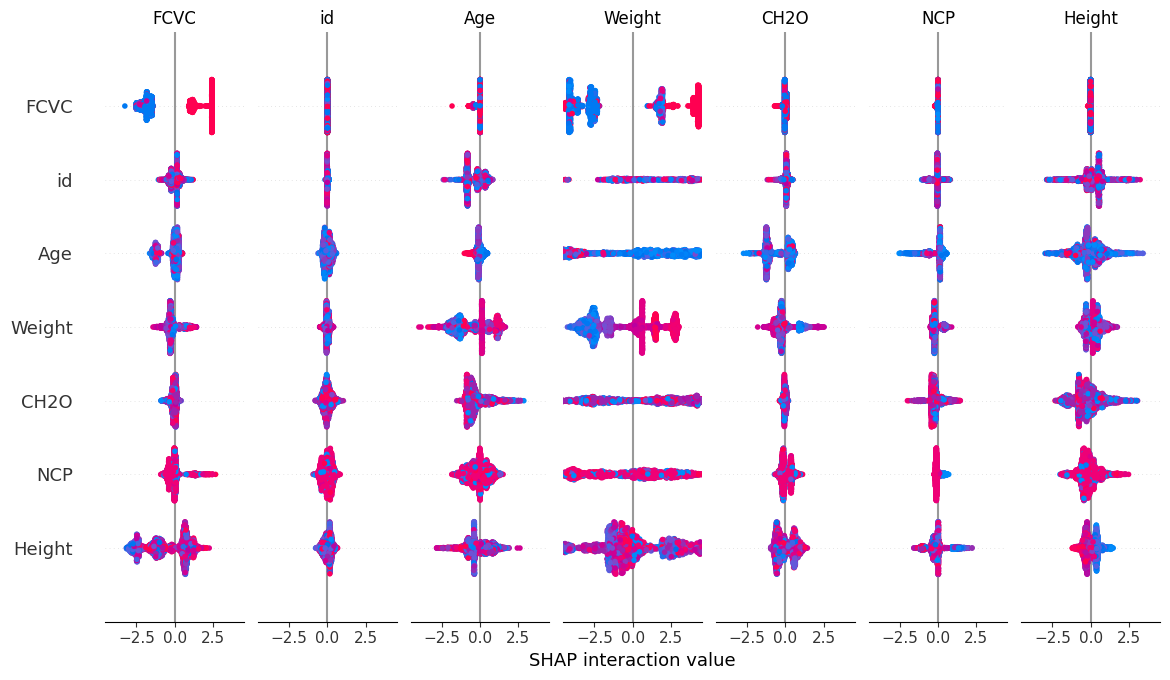

2024-03-11 13:13:54.604693: Start checking if GPU is available for usage.
Invalid Input: 'cuda', valid values are: {'approx', 'auto', 'exact', 'gpu_hist', 'hist'}
Xgboost uses CPU.
2024-03-11 13:13:54.621682: Start checking if GPU is available for usage.
Invalid Input: 'cuda', valid values are: {'approx', 'auto', 'exact', 'gpu_hist', 'hist'}
Xgboost uses CPU.
2024-03-11 13:13:54.622682: Start casting feature types.
2024-03-11 13:13:54.678695: Start filling infinite values.
2024-03-11 13:13:54.686697: Start date column conversion.
2024-03-11 13:13:54.710702: Start checking if DataFrame schema of new data is consistent with previous data.
2024-03-11 13:13:54.713703: Start transforming categories with binary target encoder.
2024-03-11 13:13:54.743710: Start transforming categories with multiclass target encoder.
2024-03-11 13:13:54.749713: Predicting...
2024-03-11 13:13:54.749713: Start predicting on new data using Xgboost model.
Finished predicting
2024-03-11 13:13:54.807724: Start rever

Best trial: 351. Best value: -0.899036: 100%|██████████| 500/500 [20:53<00:00,  2.51s/it, 1253.13/7200 seconds]


Best params: {'objective': 'multi:softprob', 'booster': 'gbtree', 'eval_metric': 'mlogloss', 'tree_method': 'exact', 'num_class': 7, 'max_depth': 7, 'alpha': 1.7922067580829657, 'lambda': 3.303796943994681, 'gamma': 0.48807509260587106, 'max_leaves': 0, 'subsample': 0.8282399491762723, 'colsample_bytree': 0.7279418412117813, 'colsample_bylevel': 0.7497831877967065, 'eta': 0.27875310524467867, 'steps': 225}
Finished hyperparameter tuning
Start final model training
2024-03-11 13:34:48.618033: Union train and test data for final model training based on TrainingConfig
             param 'use_full_data_for_final_model'
Finished training


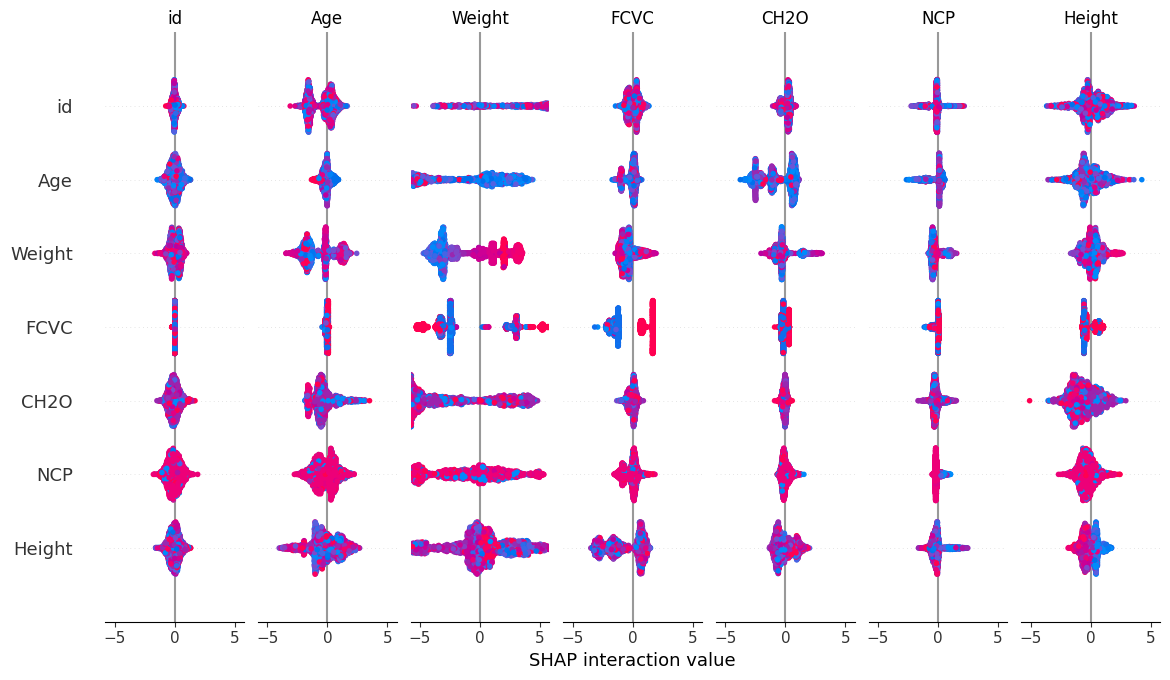

2024-03-11 13:35:11.697895: Start checking if GPU is available for usage.
Invalid Input: 'cuda', valid values are: {'approx', 'auto', 'exact', 'gpu_hist', 'hist'}
Xgboost uses CPU.
2024-03-11 13:35:11.711897: Start checking if GPU is available for usage.
Invalid Input: 'cuda', valid values are: {'approx', 'auto', 'exact', 'gpu_hist', 'hist'}
Xgboost uses CPU.
2024-03-11 13:35:11.714898: Start casting feature types.
2024-03-11 13:35:11.782913: Start filling infinite values.
2024-03-11 13:35:11.790915: Start date column conversion.
2024-03-11 13:35:11.816922: Start checking if DataFrame schema of new data is consistent with previous data.
2024-03-11 13:35:11.820923: Start transforming categories with binary target encoder.
2024-03-11 13:35:11.871937: Start transforming categories with multiclass target encoder.
2024-03-11 13:35:11.882937: Predicting...
2024-03-11 13:35:11.882937: Start predicting on new data using Xgboost model.
Finished predicting
2024-03-11 13:35:12.011851: Start rever

Best trial: 87. Best value: -0.884297: 100%|██████████| 500/500 [34:39<00:00,  4.16s/it, 2079.25/7200 seconds]  


Best params: {'objective': 'multi:softprob', 'booster': 'gbtree', 'eval_metric': 'mlogloss', 'tree_method': 'exact', 'num_class': 7, 'max_depth': 7, 'alpha': 1.7857412138504585, 'lambda': 9.705097610314299, 'gamma': 1.236121940521406, 'max_leaves': 0, 'subsample': 0.9795333674529415, 'colsample_bytree': 0.7051777943731272, 'colsample_bylevel': 0.8952932314427068, 'eta': 0.21994443495050034, 'steps': 986}
Finished hyperparameter tuning
Start final model training
2024-03-11 14:09:51.975717: Union train and test data for final model training based on TrainingConfig
             param 'use_full_data_for_final_model'
Finished training


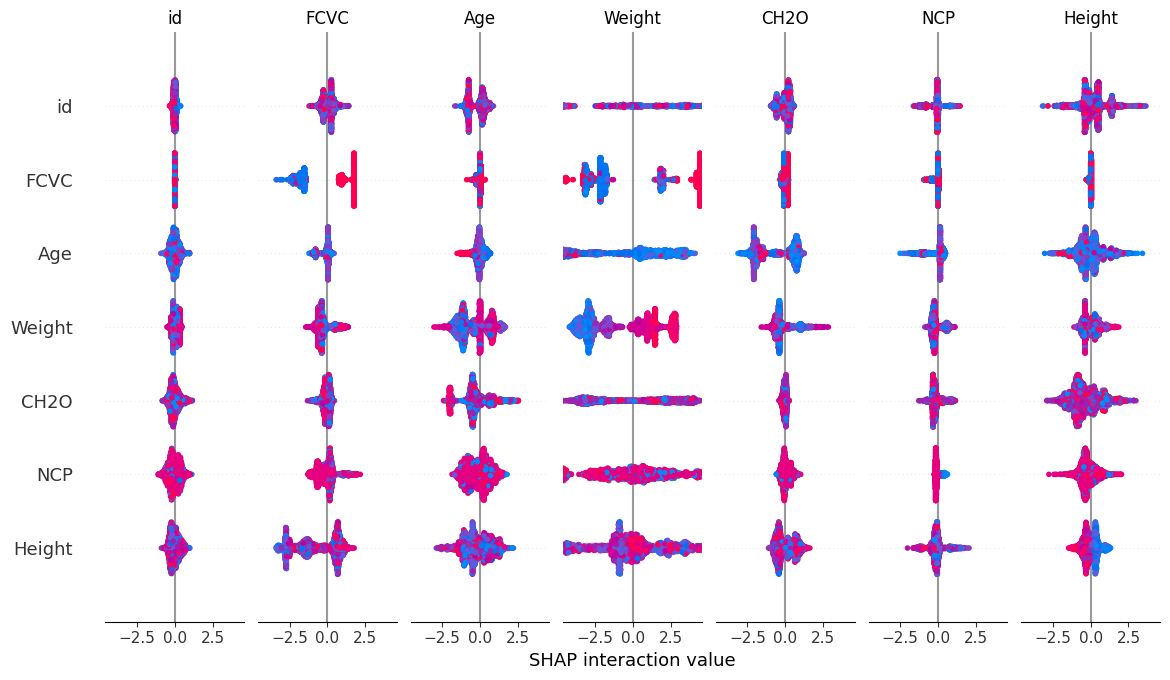

2024-03-11 14:11:03.484705: Start checking if GPU is available for usage.
Invalid Input: 'cuda', valid values are: {'approx', 'auto', 'exact', 'gpu_hist', 'hist'}
Xgboost uses CPU.
2024-03-11 14:11:03.498708: Start checking if GPU is available for usage.
Invalid Input: 'cuda', valid values are: {'approx', 'auto', 'exact', 'gpu_hist', 'hist'}
Xgboost uses CPU.
2024-03-11 14:11:03.500713: Start casting feature types.
2024-03-11 14:11:03.562723: Start filling infinite values.
2024-03-11 14:11:03.569728: Start date column conversion.
2024-03-11 14:11:03.594733: Start checking if DataFrame schema of new data is consistent with previous data.
2024-03-11 14:11:03.597733: Start transforming categories with binary target encoder.
2024-03-11 14:11:03.639749: Start transforming categories with multiclass target encoder.
2024-03-11 14:11:03.646748: Predicting...
2024-03-11 14:11:03.646748: Start predicting on new data using Xgboost model.
Finished predicting
2024-03-11 14:11:03.707755: Start rever

Best trial: 150. Best value: -0.89412: 100%|██████████| 500/500 [31:00<00:00,  3.72s/it, 1860.58/7200 seconds] 


Best params: {'objective': 'multi:softprob', 'booster': 'gbtree', 'eval_metric': 'mlogloss', 'tree_method': 'exact', 'num_class': 7, 'max_depth': 6, 'alpha': 1.1362747083270344, 'lambda': 7.509167066362655, 'gamma': 1.305272022882853, 'max_leaves': 0, 'subsample': 0.987961749615063, 'colsample_bytree': 0.8520166237874714, 'colsample_bylevel': 0.6925191199444134, 'eta': 0.18969220740819906, 'steps': 521}
Finished hyperparameter tuning
Start final model training
2024-03-11 14:42:04.944318: Union train and test data for final model training based on TrainingConfig
             param 'use_full_data_for_final_model'
Finished training


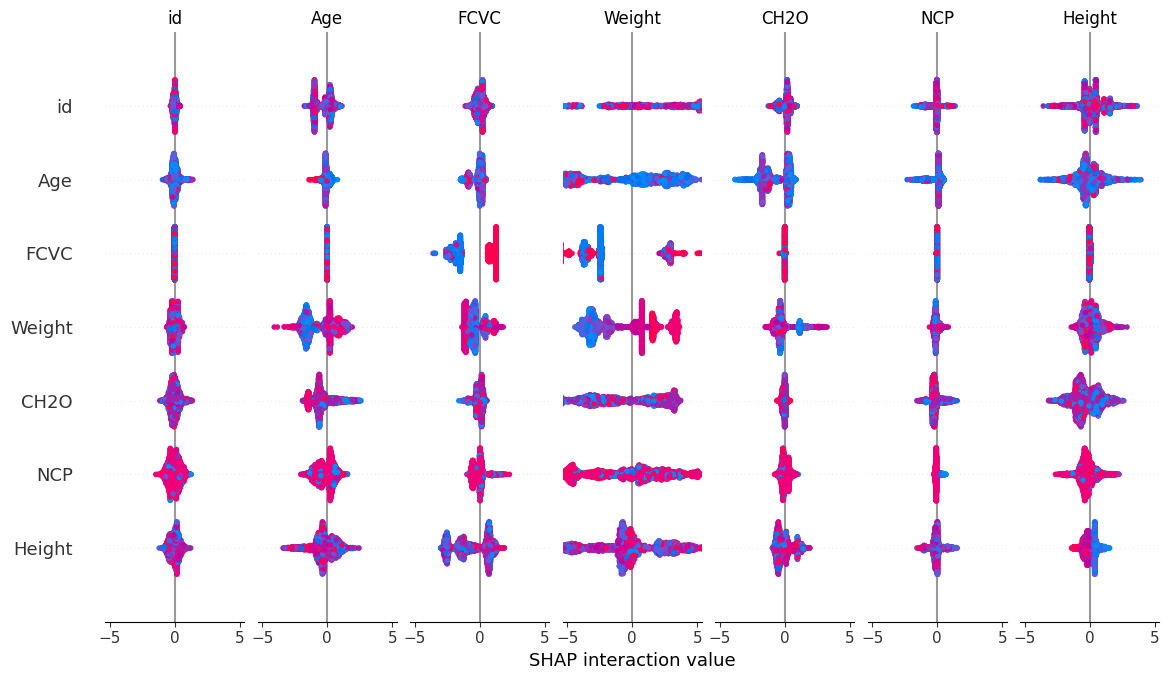

2024-03-11 14:42:38.511652: Start checking if GPU is available for usage.
Invalid Input: 'cuda', valid values are: {'approx', 'auto', 'exact', 'gpu_hist', 'hist'}
Xgboost uses CPU.
2024-03-11 14:42:38.526654: Start checking if GPU is available for usage.
Invalid Input: 'cuda', valid values are: {'approx', 'auto', 'exact', 'gpu_hist', 'hist'}
Xgboost uses CPU.
2024-03-11 14:42:38.529655: Start casting feature types.
2024-03-11 14:42:38.593670: Start filling infinite values.
2024-03-11 14:42:38.600672: Start date column conversion.
2024-03-11 14:42:38.626678: Start checking if DataFrame schema of new data is consistent with previous data.
2024-03-11 14:42:38.630679: Start transforming categories with binary target encoder.
2024-03-11 14:42:38.661686: Start transforming categories with multiclass target encoder.
2024-03-11 14:42:38.667691: Predicting...
2024-03-11 14:42:38.667691: Start predicting on new data using Xgboost model.
Finished predicting
2024-03-11 14:42:38.720698: Start rever

Best trial: 105. Best value: -0.896954: 100%|██████████| 500/500 [30:41<00:00,  3.68s/it, 1841.14/7200 seconds]  


Best params: {'objective': 'multi:softprob', 'booster': 'gbtree', 'eval_metric': 'mlogloss', 'tree_method': 'exact', 'num_class': 7, 'max_depth': 7, 'alpha': 3.9136487763126784, 'lambda': 6.354273321698924, 'gamma': 0.8061977053791521, 'max_leaves': 0, 'subsample': 0.9947865141798764, 'colsample_bytree': 0.7765556261891371, 'colsample_bylevel': 0.6854546305067588, 'eta': 0.2685236222202543, 'steps': 483}
Finished hyperparameter tuning
Start final model training
2024-03-11 15:13:20.645731: Union train and test data for final model training based on TrainingConfig
             param 'use_full_data_for_final_model'
Finished training


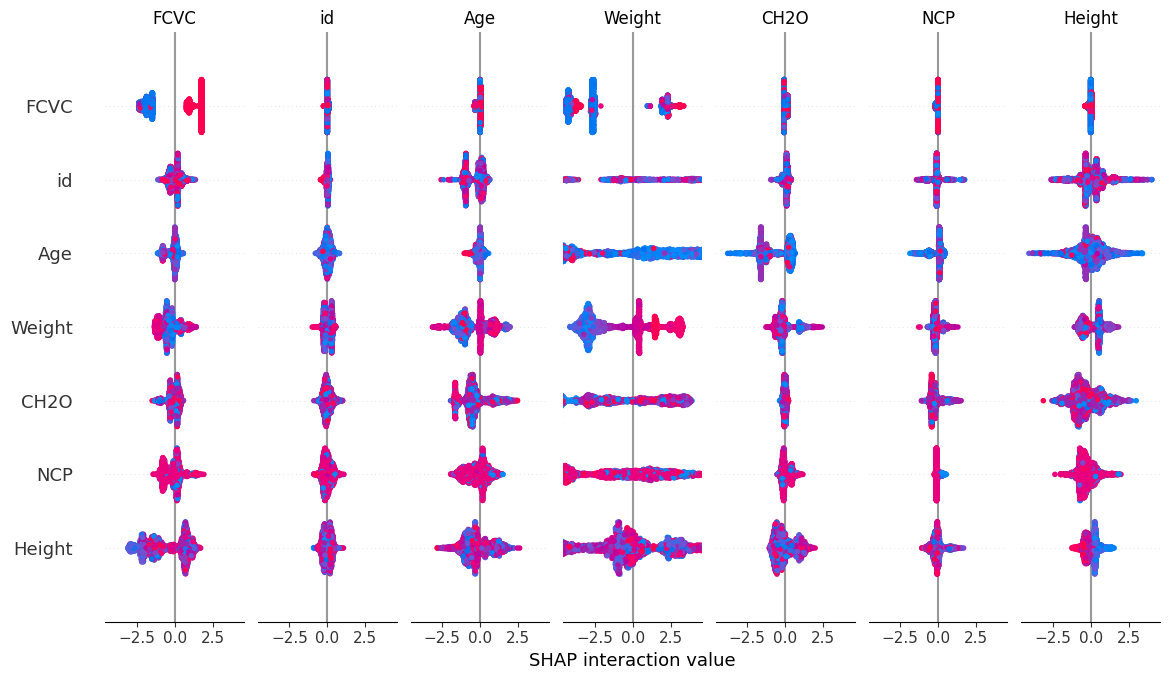

2024-03-11 15:13:56.916672: Start checking if GPU is available for usage.
Invalid Input: 'cuda', valid values are: {'approx', 'auto', 'exact', 'gpu_hist', 'hist'}
Xgboost uses CPU.
2024-03-11 15:13:56.933672: Start checking if GPU is available for usage.
Invalid Input: 'cuda', valid values are: {'approx', 'auto', 'exact', 'gpu_hist', 'hist'}
Xgboost uses CPU.
2024-03-11 15:13:56.935673: Start casting feature types.
2024-03-11 15:13:57.006285: Start filling infinite values.
2024-03-11 15:13:57.014288: Start date column conversion.
2024-03-11 15:13:57.038295: Start checking if DataFrame schema of new data is consistent with previous data.
2024-03-11 15:13:57.041301: Start transforming categories with binary target encoder.
2024-03-11 15:13:57.081305: Start transforming categories with multiclass target encoder.
2024-03-11 15:13:57.088306: Predicting...
2024-03-11 15:13:57.088306: Start predicting on new data using Xgboost model.
Finished predicting
2024-03-11 15:13:57.152318: Start rever

In [50]:
try:
    automl.fit_eval(train.copy(), target_col=target)
except Exception as e:
    print(e)

In [52]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
count=0
for model in automl.bluecast_models:
    count+=1
    # plot_tree(model.ml_model.model)
    # fig = plt.gcf()
    # fig.set_size_inches(150, 80)
    # plt.show()
print(count)

5


In [57]:
probs, classes = automl.predict(test.loc[:,['id', 'Gender', 'Age', 'Height', 'Weight',
        'family_history_with_overweight', 'FAVC', 'FCVC', 'NCP', 'CAEC',
        'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE', 'CALC', 'MTRANS', 'Gender_binary',
        'family_history_with_overweight_binary', 'SMOKE_binary']])

2024-03-11 15:21:11.443001: Start checking if GPU is available for usage.
Invalid Input: 'cuda', valid values are: {'approx', 'auto', 'exact', 'gpu_hist', 'hist'}
Xgboost uses CPU.
2024-03-11 15:21:11.474437: Start checking if GPU is available for usage.
Invalid Input: 'cuda', valid values are: {'approx', 'auto', 'exact', 'gpu_hist', 'hist'}
Xgboost uses CPU.
2024-03-11 15:21:11.478437: Start casting feature types.
2024-03-11 15:21:11.520446: Start filling infinite values.
2024-03-11 15:21:11.547453: Start date column conversion.
2024-03-11 15:21:11.626471: Start checking if DataFrame schema of new data is consistent with previous data.
2024-03-11 15:21:11.632477: Start transforming categories with binary target encoder.
2024-03-11 15:21:11.725959: Start transforming categories with multiclass target encoder.
2024-03-11 15:21:11.740961: Predicting...
2024-03-11 15:21:11.740961: Start predicting on new data using Xgboost model.
Finished predicting
2024-03-11 15:21:11.978566: Start rever

In [56]:
train.columns,test.columns

(Index(['id', 'Gender', 'Age', 'Height', 'Weight',
        'family_history_with_overweight', 'FAVC', 'FCVC', 'NCP', 'CAEC',
        'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE', 'CALC', 'MTRANS', 'NObeyesdad',
        'Gender_binary', 'family_history_with_overweight_binary',
        'SMOKE_binary'],
       dtype='object'),
 Index(['id', 'Gender', 'Age', 'Height', 'Weight',
        'family_history_with_overweight', 'FAVC', 'FCVC', 'NCP', 'CAEC',
        'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE', 'CALC', 'MTRANS', 'Gender_binary',
        'family_history_with_overweight_binary', 'SMOKE_binary',
        'class_0_proba_model_0', 'class_1_proba_model_0',
        'class_2_proba_model_0', 'class_3_proba_model_0',
        'class_4_proba_model_0', 'class_5_proba_model_0',
        'class_6_proba_model_0', 'classes_0', 'class_0_proba_model_1',
        'class_1_proba_model_1', 'class_2_proba_model_1',
        'class_3_proba_model_1', 'class_4_proba_model_1',
        'class_5_proba_model_1', 'class_6_proba_mode

In [58]:
# access the experiment tracker if needed
tracker = automl.experiment_tracker
tracker

In [59]:
# see all stored information as a Pandas DataFrame
tracker_df = tracker.retrieve_results_as_df()
tracker_df

,experiment_id,score_category,eval_scores,metric_used,metric_higher_is_better,global_random_state,increase_random_state_in_bluecast_cv_by,shuffle_during_training,hyperparameter_tuning_rounds,hyperparameter_tuning_max_runtime_secs,...,num_class,eta,max_depth,alpha,lambda,gamma,max_leaves,subsample,colsample_bytree,colsample_bylevel
0,0,simple_train_test_score,-0.884588,matthew_inverse,False,963,33,True,500,7200,...,7,0.035246,2,6.675524,8.089219,0.635781,0,0.406505,0.995343,0.733349
1,1,simple_train_test_score,-0.861720,matthew_inverse,False,963,33,True,500,7200,...,7,0.214888,2,2.865135,7.022101,0.074710,0,0.778240,0.307349,0.866389
2,2,simple_train_test_score,-0.868469,matthew_inverse,False,963,33,True,500,7200,...,7,0.215540,6,2.501854,9.681428,7.249707,0,0.429691,0.417298,0.518724
3,3,simple_train_test_score,-0.853743,matthew_inverse,False,963,33,True,500,7200,...,7,0.051332,3,9.263005,9.173420,6.772594,0,0.356709,0.949787,0.900586
4,4,simple_train_test_score,-0.876200,matthew_inverse,False,963,33,True,500,7200,...,7,0.225585,2,3.458860,9.870537,9.720822,0,0.968724,0.644654,0.708275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416,385,oof_score,0.905083,f1_score_weighted,True,1095,33,True,500,7200,...,7,0.268524,7,3.913649,6.354273,0.806198,0,0.994787,0.776556,0.685455
417,385,oof_score,0.905083,log_loss,False,1095,33,True,500,7200,...,7,0.268524,7,3.913649,6.354273,0.806198,0,0.994787,0.776556,0.685455
418,385,oof_score,0.905083,balanced_logloss,False,1095,33,True,500,7200,...,7,0.268524,7,3.913649,6.354273,0.806198,0,0.994787,0.776556,0.685455
419,385,oof_score,0.905083,roc_auc,True,1095,33,True,500,7200,...,7,0.268524,7,3.913649,6.354273,0.806198,0,0.994787,0.776556,0.685455


In [60]:
tracker_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421 entries, 0 to 420
Data columns (total 42 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   experiment_id                              421 non-null    int64  
 1   score_category                             421 non-null    object 
 2   eval_scores                                421 non-null    float64
 3   metric_used                                421 non-null    object 
 4   metric_higher_is_better                    421 non-null    bool   
 5   global_random_state                        421 non-null    int64  
 6   increase_random_state_in_bluecast_cv_by    421 non-null    int64  
 7   shuffle_during_training                    421 non-null    bool   
 8   hyperparameter_tuning_rounds               421 non-null    int64  
 9   hyperparameter_tuning_max_runtime_secs     421 non-null    int64  
 10  hypertuning_cv_folds      

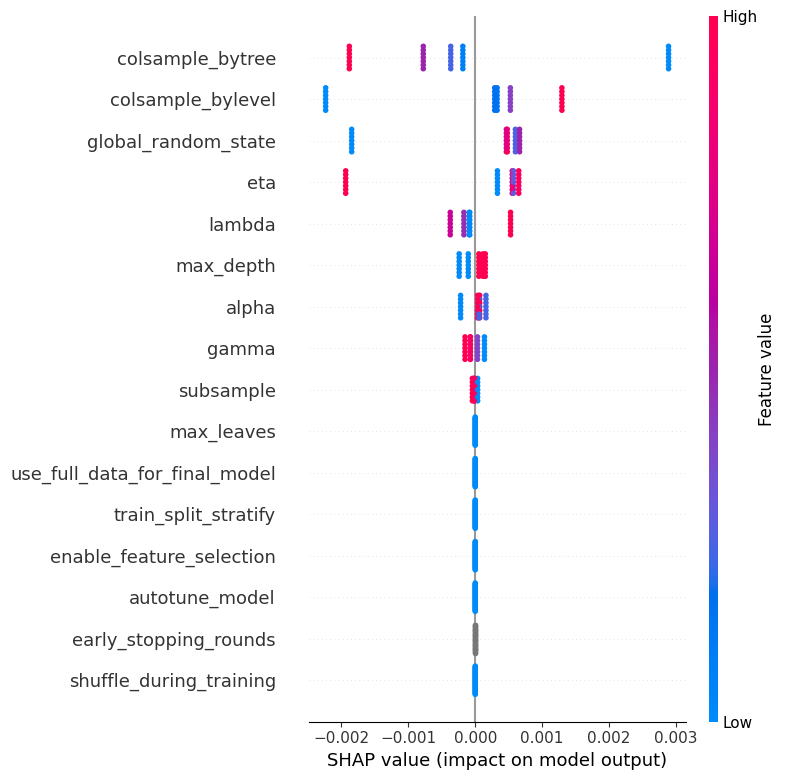

In [61]:
from sklearn.ensemble import RandomForestRegressor
import shap 

cols = [
    "shuffle_during_training",
    "global_random_state",
    "early_stopping_rounds",
    "autotune_model",
    "enable_feature_selection",
    "train_split_stratify",
    "use_full_data_for_final_model",
    "eta",
    "max_depth",
    "alpha",
    "lambda",
    "gamma",
    "max_leaves",
    "subsample",
    "colsample_bytree",
    "colsample_bylevel"
]

regr = RandomForestRegressor(max_depth=4, random_state=0)

tracker_df = tracker_df.loc[tracker_df["score_category"] == "oof_score"]

experiment_feats_df, experiment_feats_target = tracker_df.loc[:, cols], tracker_df.loc[:, "eval_scores"]

regr.fit(experiment_feats_df.fillna(0), experiment_feats_target.fillna(99))

explainer = shap.TreeExplainer(regr)


shap_values = explainer.shap_values(experiment_feats_df)
shap.summary_plot(shap_values, experiment_feats_df)

In [63]:
# save pipeline including tracker
save_to_production(automl, "model/", "bluecast_cv_pipeline")

# in production or for further experiments this can be loaded again
automl_loaded = load_for_production("model/", "bluecast_cv_pipeline")

2024-03-11 15:36:30.939419: Start saving class instance.
2024-03-11 15:36:31.873680: Start loading class instance.


In [64]:
probs

0        0.142857
1        0.142857
2        0.142857
3        0.142857
4        0.142857
           ...   
13835    0.142857
13836    0.142857
13837    0.142857
13838    0.142857
13839    0.142857
Length: 13840, dtype: float32

In [65]:
submission[target] = probs
submission.to_csv('submission.csv', index=False)

In [ ]:
submission